<a href="https://colab.research.google.com/github/susie682/Infosys722--Assignment-4-BDAS/blob/main/3_5_Formatting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Section 3.5 — Formatting Data (Inline Figures)

This version **both saves and displays** figures inside the notebook using `display(fig)` and `plt.close(fig)` to avoid duplicate renders.



**Environment**: Google Colab + PySpark  
**Input**: `/content/drive/MyDrive/Infosys 722/CrimeData_2017.csv`  
**Outputs**:  
- Figures → `/content/drive/MyDrive/Infosys 722/figs/` (Fig. 41 & 42)  
- Tables  → `/content/drive/MyDrive/Infosys 722/tables/` (`features_district_month.csv`)


In [1]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# If needed:
# !apt-get install -y openjdk-11-jdk-headless -qq
# !pip install -q pyspark==3.5.1

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PYSPARK_PYTHON"] = "python3"
print("Environment ready.")


Mounted at /content/drive
Environment ready.


In [2]:

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("BDAS-3.5-Formatting-Inline").getOrCreate()
spark


In [3]:

DATA_PATH = "/content/drive/MyDrive/Infosys 722/CrimeData_2017.csv"
FIG_DIR  = "/content/drive/MyDrive/Infosys 722/figs"
TAB_DIR  = "/content/drive/MyDrive/Infosys 722/tables"
import os
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)
print("Using:", DATA_PATH)


Using: /content/drive/MyDrive/Infosys 722/CrimeData_2017.csv


In [4]:

from pyspark.sql import functions as F

df_raw = spark.read.csv(DATA_PATH, header=True, inferSchema=True)

canonical_cols = [
    "ID","Case Number","Date","Block","IUCR","Primary Type","Description",
    "Location Description","Arrest","Domestic","Beat","District","Ward",
    "Community Area","FBI Code","X Coordinate","Y Coordinate","Year",
    "Updated On","Latitude","Longitude","Location"
]

def norm(s): return "".join(ch.lower() for ch in s if ch.isalnum())
raw_norm_map = {norm(c): c for c in df_raw.columns}

found = {}
for c in canonical_cols:
    key = norm(c)
    if key in raw_norm_map:
        found[c] = raw_norm_map[key]

select_exprs = [F.col(found[c]).alias(c) for c in canonical_cols if c in found]
df_base = df_raw.select(*select_exprs)

print("df_base columns:", len(df_base.columns))
print("Row count:", df_base.count())


df_base columns: 22
Row count: 267562


In [7]:
from pyspark.sql import functions as F

def to_binary_safe(colname: str):
    """
    Robust 0/1 encoder:
    - Cast to string, trim, lowercase
    - Treat 1/y/yes/true/t as 1; everything else (incl. null) as 0
    """
    s = F.lower(F.trim(F.col(colname).cast("string")))
    return F.when(s.isin("1", "y", "yes", "true", "t"), 1).otherwise(0)

df_proc = (
    df_base
    .withColumn("Arrest_bin",   to_binary_safe("Arrest"))
    .withColumn("Domestic_bin", to_binary_safe("Domestic"))
    .withColumn("ts", F.to_timestamp("Date", "MM/dd/yyyy hh:mm:ss a"))
    .withColumn("Year", F.year("ts"))
    .filter(F.col("Year") == 2017)
    .withColumn("Month", F.month("ts"))
    .withColumn("DayOfWeek", F.date_format("ts","u").cast("int"))
    .withColumn("Hour", F.hour("ts"))
    .withColumn("HourBin",
        F.when(F.col("Hour").between(0,5), 0)
         .when(F.col("Hour").between(6,11), 1)
         .when(F.col("Hour").between(12,17), 2)
         .otherwise(3)
    )
)


Saved Figure 41: /content/drive/MyDrive/Infosys 722/figs/fig41_arrest_canonicalized.png


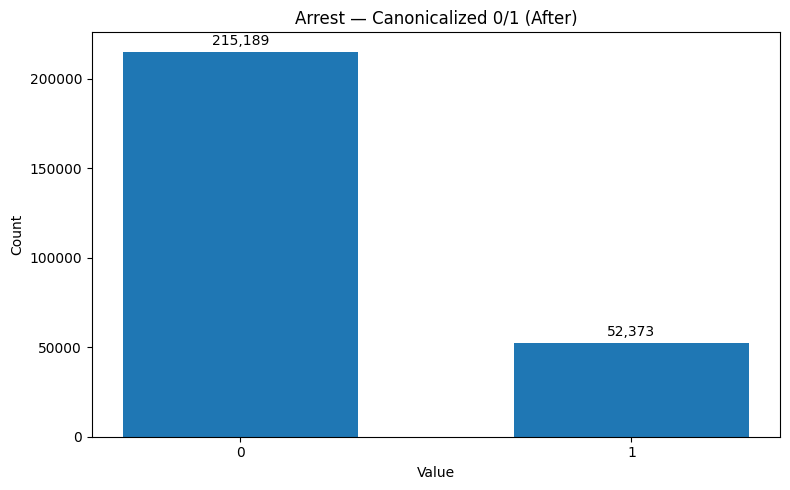

In [8]:

# Figure 41 — Save AND display inline
import matplotlib.pyplot as plt
from IPython.display import display

counts_arrest = df_proc.groupBy("Arrest_bin").count().orderBy("Arrest_bin").toPandas()
vals = counts_arrest["Arrest_bin"].values
cts  = counts_arrest["count"].values

fig, ax = plt.subplots(figsize=(8,5))
bars = ax.bar(vals, cts, width=0.6)
for b, c in zip(bars, cts):
    ax.text(b.get_x()+b.get_width()/2, c+max(cts)*0.01, f"{c:,}", ha="center", va="bottom")
ax.set_xticks(vals); ax.set_xlabel("Value"); ax.set_ylabel("Count")
ax.set_title("Arrest — Canonicalized 0/1 (After)")
fig.tight_layout()

fig_path_41 = f"{FIG_DIR}/fig41_arrest_canonicalized.png"
fig.savefig(fig_path_41, bbox_inches="tight", dpi=150)
print("Saved Figure 41:", fig_path_41)

display(fig)
plt.close(fig)


Saved Figure 42: /content/drive/MyDrive/Infosys 722/figs/fig42_domestic_canonicalized.png


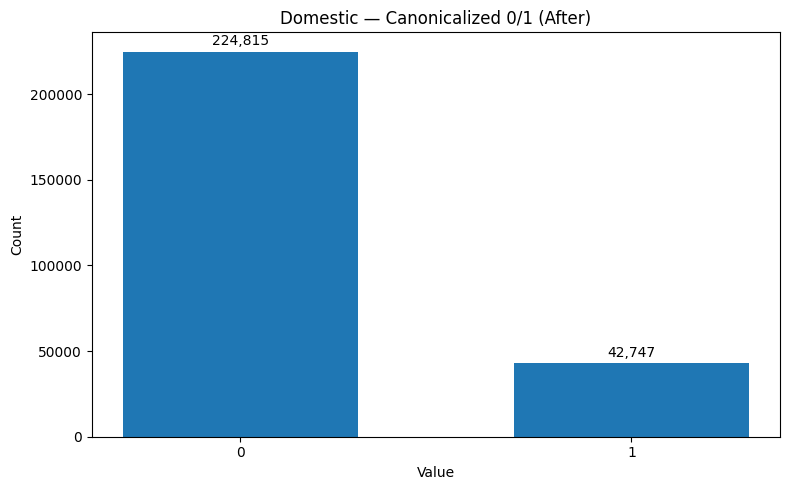

In [9]:

# Figure 42 — Save AND display inline
import matplotlib.pyplot as plt
from IPython.display import display

counts_domestic = df_proc.groupBy("Domestic_bin").count().orderBy("Domestic_bin").toPandas()
vals = counts_domestic["Domestic_bin"].values
cts  = counts_domestic["count"].values

fig, ax = plt.subplots(figsize=(8,5))
bars = ax.bar(vals, cts, width=0.6)
for b, c in zip(bars, cts):
    ax.text(b.get_x()+b.get_width()/2, c+max(cts)*0.01, f"{c:,}", ha="center", va="bottom")
ax.set_xticks(vals); ax.set_xlabel("Value"); ax.set_ylabel("Count")
ax.set_title("Domestic — Canonicalized 0/1 (After)")
fig.tight_layout()

fig_path_42 = f"{FIG_DIR}/fig42_domestic_canonicalized.png"
fig.savefig(fig_path_42, bbox_inches="tight", dpi=150)
print("Saved Figure 42:", fig_path_42)

display(fig)
plt.close(fig)


In [10]:

from pyspark.sql import functions as F, Window

grp = ["District","Month"]
total = df_proc.groupBy(*grp).agg(
    F.count(F.lit(1)).alias("Total"),
    F.sum("Arrest_bin").alias("Arrests"),
    F.sum("Domestic_bin").alias("Domestics"),
    F.sum(F.when(F.col("HourBin")==0, 1).otherwise(0)).alias("NightCnt")
)

feat = (total
    .withColumn("ArrestRate",  (F.col("Arrests")/F.col("Total")).cast("double"))
    .withColumn("DomesticRate",(F.col("Domestics")/F.col("Total")).cast("double"))
    .withColumn("NightShare",  (F.col("NightCnt")/F.col("Total")).cast("double"))
)

w = Window.partitionBy("District").orderBy("Month")

feat = (feat
    .withColumn("Lag1_Total", F.lag("Total", 1).over(w))
    .withColumn("Lag3_Total", F.lag("Total", 3).over(w))
    .withColumn("Roll3_Total", F.avg("Total").over(w.rowsBetween(-2,0)))
)

# Impute lag-induced NaNs via within-district medians
med = feat.groupBy("District").agg(
    F.expr("percentile_approx(Lag1_Total, 0.5)").alias("med_Lag1"),
    F.expr("percentile_approx(Lag3_Total, 0.5)").alias("med_Lag3"),
    F.expr("percentile_approx(Roll3_Total, 0.5)").alias("med_Roll3"),
)
feat_imp = (feat.alias("f")
  .join(med.alias("m"), on="District", how="left")
  .selectExpr("f.*",
              "COALESCE(Lag1_Total, med_Lag1) as Lag1_Total_imp",
              "COALESCE(Lag3_Total, med_Lag3) as Lag3_Total_imp",
              "COALESCE(Roll3_Total, med_Roll3) as Roll3_Total_imp")
)

# Save modelling table (single-file folder)
out_dir = "/content/drive/MyDrive/Infosys 722/tables/features_district_month.csv"
(feat_imp.orderBy("District","Month")
 .coalesce(1).write.mode("overwrite").option("header", True).csv(out_dir))
print("Wrote modelling table to:", out_dir)


Wrote modelling table to: /content/drive/MyDrive/Infosys 722/tables/features_district_month.csv
